<a href="https://colab.research.google.com/github/Cristianmmm/CSCI164/blob/main/NameToGender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
!pip install mysql-connector-python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, roc_auc_score, roc_curve

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 15.0 MB/s eta 0:00:00


In [3]:
#https://drive.google.com/file/d/17cP0ZW0bKe2LpcSjInNGpndiKKBOgKo2/view?usp=sharing
!gdown --id 17cP0ZW0bKe2LpcSjInNGpndiKKBOgKo2

#Load the dataset and remove missig values
genderData = pd.read_csv('name_gender_dataset.csv').dropna()

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17cP0ZW0bKe2LpcSjInNGpndiKKBOgKo2
To: /content/name_gender_dataset.csv
100% 3.77M/3.77M [00:00<00:00, 27.3MB/s]


In [4]:
#Read the data set
genderData = pd.read_csv('name_gender_dataset.csv')

#Group by name and gender to sum count
genderGroup = genderData.groupby(['Name', 'Gender'])['Count'].sum().unstack(fill_value=0)

#Columns with M and F count per name
genderGroup['Total'] = genderGroup['M'] + genderGroup['F']
genderGroup['MajorGender'] = genderGroup[['M', 'F']].idxmax(axis=1)

#Reset index to have 'Name' as column
genderGroup.reset_index(inplace=True)

#Vectorize data with TfidfVectorizer
X = genderGroup['Name']
y = genderGroup['MajorGender']

In [9]:
#Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, train_size=0.5)

#Fit Vectorizer with test and training data for  n-grams(characters)
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3))
X_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [10]:
#Initialize the models(Knn, Naive Bayes, Logistic)
models = {
  'Logistic Regression': LogisticRegression(max_iter=1000),
  'k-NN': KNeighborsClassifier(),
  'Naive Bayes': MultinomialNB()
}

In [11]:
#Parameters for each model for Hyper Tuning
param_grid = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l2']},
    'k-NN': {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']},
    'Naive Bayes': {'alpha': [0.1, 1, 10]}
}

In [12]:
#Loops through all models using GridSearch to find best parameters
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy')
    grid_search.fit(X_tfidf, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"{name} Best Parameters: {grid_search.best_params_}")


Logistic Regression Best Parameters: {'C': 10, 'penalty': 'l2'}
k-NN Best Parameters: {'n_neighbors': 5, 'weights': 'uniform'}
Naive Bayes Best Parameters: {'alpha': 0.1}


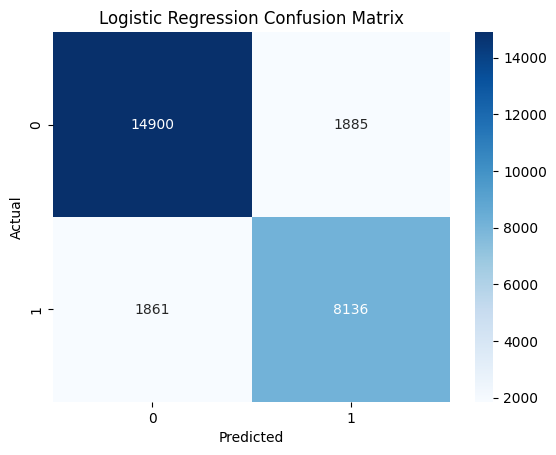

<Figure size 800x600 with 0 Axes>

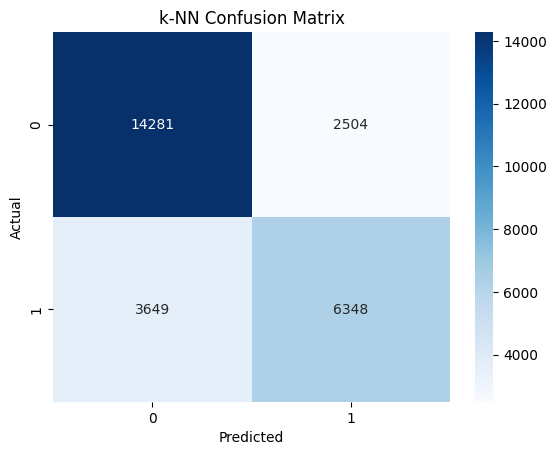

<Figure size 800x600 with 0 Axes>

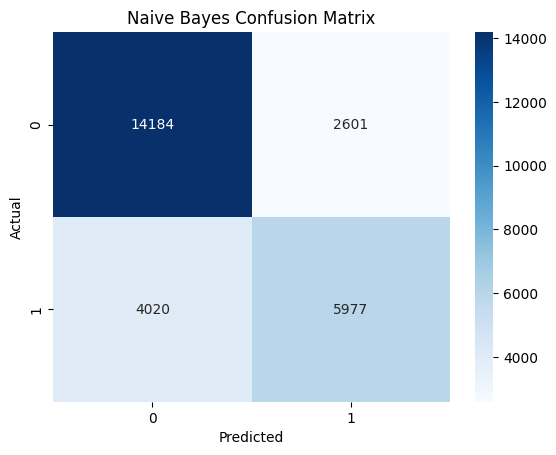

<Figure size 800x600 with 0 Axes>

In [40]:
#Evaluate the models
results= {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_tfidf)
    y_proba = model.predict_proba(X_test_tfidf) if hasattr(model, 'predict_proba') else [0]*len(y_test) #Fixed lenb to len
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred, pos_label='F'),
        'Precision': precision_score(y_test, y_pred, pos_label='F'),
        'ROC-AUC': roc_auc_score(y_test, y_proba[:, 1]) if y_proba is not None else 'N/A'
    }

    #Confusion Matrix'
    conMatrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conMatrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    plt.figure(figsize=(8,6))
    plt.show()

In [16]:
#Print the results for different scoring metrics
for model, metrics in results.items():
    print(f"--- {model} ---")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1-score: {metrics['F1-score']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    if metrics['ROC-AUC'] is not None:
        print(f"ROC-AUC: {metrics['ROC-AUC']:.4f}")

--- Logistic Regression ---
Accuracy: 0.8601
F1-score: 0.8883
Precision: 0.8890
ROC-AUC: 0.9280
--- k-NN ---
Accuracy: 0.7703
F1-score: 0.8228
Precision: 0.7965
ROC-AUC: 0.8251
--- Naive Bayes ---
Accuracy: 0.7528
F1-score: 0.8108
Precision: 0.7792
ROC-AUC: 0.8241


In [39]:
#Input a name to test
name = input("Enter a name: ")
name_vec = vectorizer.transform([name])
prediction = best_models['Logistic Regression'].predict(name_vec)[0]
print(f"Predicted gender for {name}: {prediction}")


Enter a name: Baconeggandcheese
Predicted gender for Baconeggandcheese: F
